# 1.Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Load the dataset
data = pd.read_csv(r'C:\Users\Raiyana Reyaz\OneDrive\Desktop\data science assignments\RNN\monthly_milk_production.csv')  
data.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [5]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data.set_index('Date', inplace=True)

In [7]:
data.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


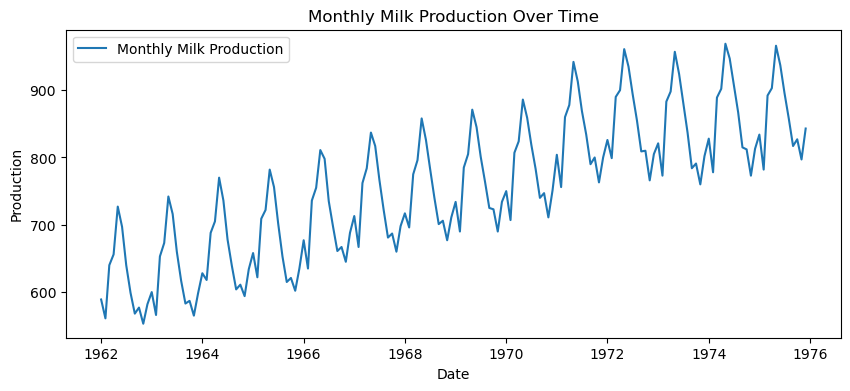

In [8]:
# Plot original series
plt.figure(figsize=(10,4))
plt.plot(data['Production'], label='Monthly Milk Production')
plt.title('Monthly Milk Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

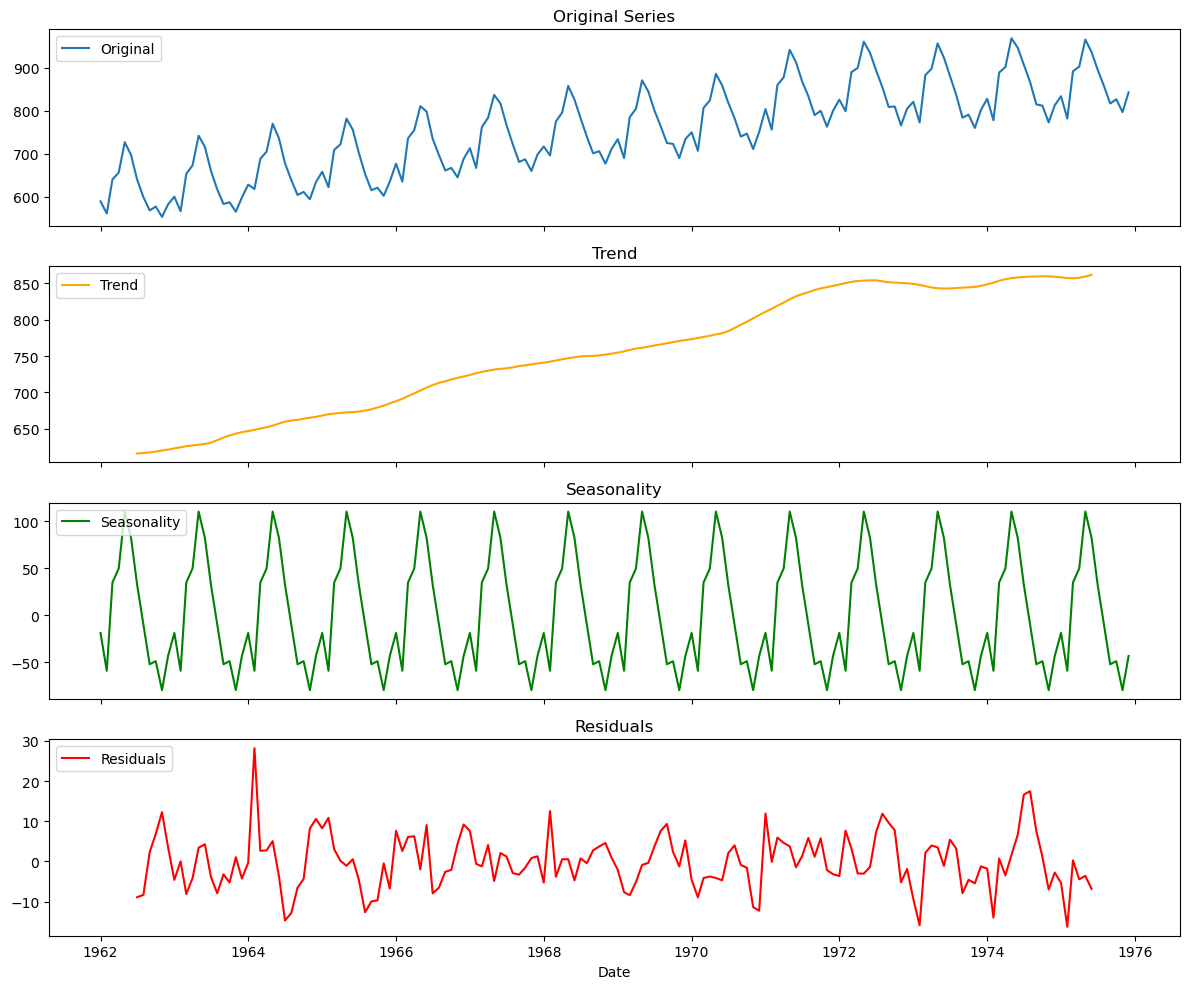

In [9]:
# Decompose the time series
decomposition = seasonal_decompose(data['Production'], model='additive')

# Plot original, trend, seasonality, and residuals
fig, axes = plt.subplots(4,1, figsize=(12,10), sharex=True)
axes[0].plot(data['Production'], label='Original')
axes[0].legend(loc='upper left')
axes[0].set_title('Original Series')

axes[1].plot(decomposition.trend, label='Trend', color='orange')
axes[1].legend(loc='upper left')
axes[1].set_title('Trend')

axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
axes[2].legend(loc='upper left')
axes[2].set_title('Seasonality')

axes[3].plot(decomposition.resid, label='Residuals', color='red')
axes[3].legend(loc='upper left')
axes[3].set_title('Residuals')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [10]:
print("Missing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Production    0
dtype: int64


In [11]:
# Summary statistics to spot extreme values
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


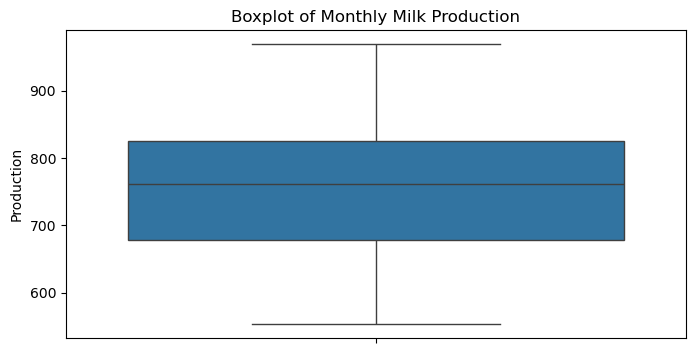

In [14]:
# Visualize for outliers using boxplot
import seaborn as sns
plt.figure(figsize=(8,4))
sns.boxplot(data['Production'])
plt.title('Boxplot of Monthly Milk Production')
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
production_scaled = scaler.fit_transform(data[['Production']])
data_scaled = pd.DataFrame(production_scaled, index=data.index, columns=['Production_scaled'])

print(data_scaled.head())

            Production_scaled
Date                         
1962-01-01           0.086538
1962-02-01           0.019231
1962-03-01           0.209135
1962-04-01           0.247596
1962-05-01           0.418269


# 2.Data Preparation for Deep Learning

In [18]:
from sklearn.model_selection import train_test_split
n_steps = 12 

X = []
y = []

for i in range(n_steps, len(data_scaled)):
    X.append(data_scaled.iloc[i-n_steps:i, 0].values)  # past 12 months
    y.append(data_scaled.iloc[i, 0])                   # next month

X, y = np.array(X), np.array(y)

print("X shape before reshape:", X.shape)
print("y shape:", y.shape)

X shape before reshape: (156, 12)
y shape: (156,)


In [20]:
# Split data: 70% train, 15% validation, 15% test 
(#Validation set is used to tune the model and monitor its performance during training without touching the test set.)
    
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, shuffle=False)  
# 0.1765 ≈ 15% of total for validation

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (108, 12)
Validation set shape: (24, 12)
Test set shape: (24, 12)


In [21]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train reshaped:", X_train.shape)
print("X_val reshaped:", X_val.shape)
print("X_test reshaped:", X_test.shape)

X_train reshaped: (108, 12, 1)
X_val reshaped: (24, 12, 1)
X_test reshaped: (24, 12, 1)


# 3.Model Building

In [22]:
# RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import tensorflow as tf

# Set seed for reproducibility
tf.random.set_seed(42)

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dense(1))  # Predict next month's production

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse')

# Train the model
history = rnn_model.fit( X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

C:\Users\Raiyana Reyaz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1790 - val_loss: 0.1851
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0501 - val_loss: 0.0348
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0304 - val_loss: 0.0244
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0184 - val_loss: 0.0163
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0134 - val_loss: 0.0197
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0129 - val_loss: 0.0157
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0094 - val_loss: 0.0115
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0090 - val_loss: 0.0107
E

In [26]:
last_n_steps = data_scaled[-n_steps:].values.reshape(1, n_steps, 1)
predicted_scaled = rnn_model.predict(last_n_steps)
predicted_production = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next month's milk production (RNN): {predicted_production[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted next month's milk production (RNN): 864.00


In [24]:
# LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# Set seed for reproducibility
tf.random.set_seed(42)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
history_lstm = lstm_model.fit( X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50


C:\Users\Raiyana Reyaz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.2185 - val_loss: 0.4675
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1599 - val_loss: 0.3354
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1054 - val_loss: 0.1998
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0528 - val_loss: 0.0569
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0295 - val_loss: 0.0212
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0288 - val_loss: 0.0275
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0238 - val_loss: 0.0434
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0245 - val_loss: 0.0322
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0227 - val_loss: 0.0219
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0219 - val_loss: 0.0214
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0209 - val_loss: 0.0226
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0205 - val_loss: 0.0201
Epoch 13/50

In [25]:
last_n_steps = data_scaled[-n_steps:].values.reshape(1, n_steps, 1)
predicted_scaled = lstm_model.predict(last_n_steps)
predicted_production = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next month's milk production (LSTM): {predicted_production[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Predicted next month's milk production (LSTM): 840.98


In [27]:
# GRU
from tensorflow.keras.layers import GRU, Dense

# Set seed for reproducibility
tf.random.set_seed(42)

# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], 1)))
gru_model.add(Dense(1))  

# Compile the model
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
history_gru = gru_model.fit(X_train, y_train,epochs=50,batch_size=16,validation_data=(X_val, y_val), verbose=1)

Epoch 1/50


C:\Users\Raiyana Reyaz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.1479 - val_loss: 0.3179
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1098 - val_loss: 0.2354
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0726 - val_loss: 0.1492
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0423 - val_loss: 0.0765
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0269 - val_loss: 0.0343
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0250 - val_loss: 0.0259
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0227 - val_loss: 0.0329
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0211 - val_loss: 0.0411
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0213 - val_loss: 0.0384
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0207 - val_loss: 0.0323
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0203 - val_loss: 0.0299
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0198 - val_loss: 0.0306
Epoch 13/50

In [28]:
last_n_steps = data_scaled[-n_steps:].values.reshape(1, n_steps, 1)
predicted_scaled = gru_model.predict(last_n_steps)
predicted_production = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next month's milk production (GRU): {predicted_production[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
Predicted next month's milk production (GRU): 839.37


In [29]:
#	Tune hyperparameters (e.g., window size, number of units, batch size, epochs).

# Function to build models
def build_model(model_type='RNN', units=50, input_shape=(X_train.shape[1], 1)):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, activation='relu', input_shape=input_shape))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation='relu', input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(units, activation='relu', input_shape=input_shape))
    else:
        raise ValueError("model_type must be 'RNN', 'LSTM', or 'GRU'")
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Hyperparameters to try
units_list = [30, 50]
batch_sizes = [16, 32]
epochs_list = [50, 100]

best_models = {}

# Loop through all model types
for model_type in ['RNN', 'LSTM', 'GRU']:
    best_val_loss = float('inf')
    best_model = None
    
    print(f"\nTuning {model_type} model...")
    
    for units in units_list:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                print(f"Training {model_type} | units={units}, batch_size={batch_size}, epochs={epochs}")
                
                tf.random.set_seed(42)  # reproducibility
                
                model = build_model(model_type=model_type, units=units)
                
                history = model.fit(
                    X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0
                )
                
                val_loss = history.history['val_loss'][-1]
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    
    best_models[model_type] = best_model
    print(f"Best {model_type} model | Validation Loss: {best_val_loss:.6f}")


Tuning RNN model...
Training RNN | units=30, batch_size=16, epochs=50


C:\Users\Raiyana Reyaz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | units=30, batch_size=16, epochs=100
Training RNN | units=30, batch_size=32, epochs=50
Training RNN | units=30, batch_size=32, epochs=100
Training RNN | units=50, batch_size=16, epochs=50
Training RNN | units=50, batch_size=16, epochs=100
Training RNN | units=50, batch_size=32, epochs=50
Training RNN | units=50, batch_size=32, epochs=100
Best RNN model | Validation Loss: 0.001354

Tuning LSTM model...
Training LSTM | units=30, batch_size=16, epochs=50
Training LSTM | units=30, batch_size=16, epochs=100
Training LSTM | units=30, batch_size=32, epochs=50
Training LSTM | units=30, batch_size=32, epochs=100
Training LSTM | units=50, batch_size=16, epochs=50
Training LSTM | units=50, batch_size=16, epochs=100
Training LSTM | units=50, batch_size=32, epochs=50
Training LSTM | units=50, batch_size=32, epochs=100
Best LSTM model | Validation Loss: 0.012854

Tuning GRU model...
Training GRU | units=30, batch_size=16, epochs=50
Training GRU | units=30, batch_size=16, epochs=100
Tra

After hyperparameter tuning, the RNN model achieved the lowest validation loss (0.001354), followed by GRU (0.004879) and LSTM (0.012854). This indicates that for this dataset, the basic RNN is sufficient to capture the monthly milk production patterns, while the more complex LSTM and GRU models do not provide additional benefit.

In [ ]:
#Loss Function and Optimizer
#Since the task is to predict monthly milk production, which is a continuous numeric value,
#we use Mean Squared Error (MSE) as the loss function. MSE penalizes larger errors more heavily, 
#which helps the model focus on accurate predictions.

#For optimization, we use the Adam optimizer, which adapts the learning rate during training, 
#ensuring faster and stable convergence. 
#The same loss function and optimizer are applied for all three models: RNN, LSTM, and GRU.

# 4.Model Evaluation


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


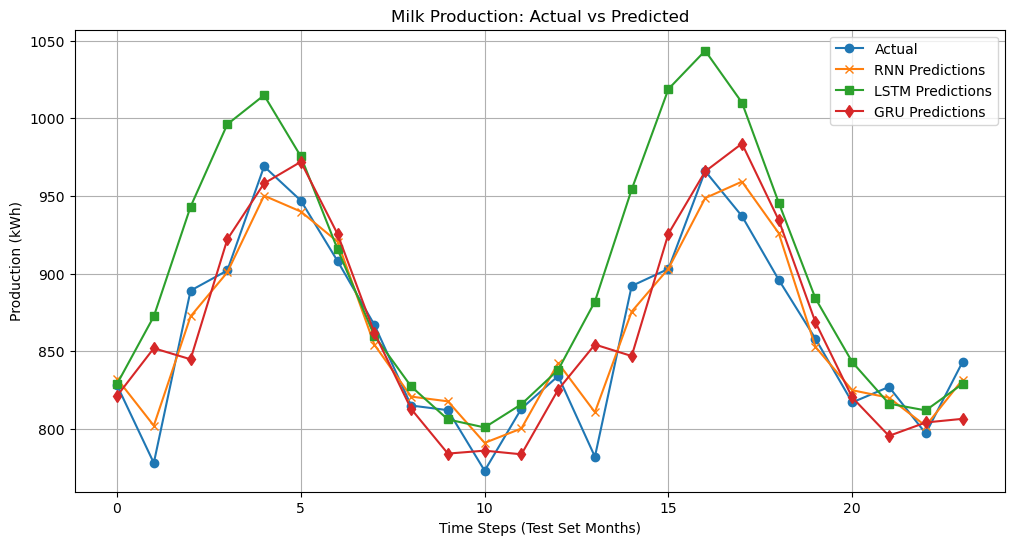

In [30]:
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_rnn = best_models['RNN'].predict(X_test)
y_pred_lstm = best_models['LSTM'].predict(X_test)
y_pred_gru = best_models['GRU'].predict(X_test)

# Inverse transform to original scale
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rnn_orig = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_orig = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_orig = scaler.inverse_transform(y_pred_gru)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_test_orig, label='Actual', marker='o')
plt.plot(y_pred_rnn_orig, label='RNN Predictions', marker='x')
plt.plot(y_pred_lstm_orig, label='LSTM Predictions', marker='s')
plt.plot(y_pred_gru_orig, label='GRU Predictions', marker='d')
plt.title('Milk Production: Actual vs Predicted')
plt.xlabel('Time Steps (Test Set Months)')
plt.ylabel('Production (kWh)')
plt.legend()
plt.grid(True)
plt.show()

The predictions from the three models were compared against the actual milk production values. The RNN model closely followed the actual trend, capturing the monthly variations accurately. The GRU model performed moderately well, but its predictions were slightly off at some points. The LSTM model deviated the most from the actual values, indicating that for this dataset, the simpler RNN is more effective than the more complex LSTM and GRU models.

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate RMSE, MAE, MAPE
def forecast_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# Calculate metrics for each model
rmse_rnn, mae_rnn, mape_rnn = forecast_metrics(y_test_orig, y_pred_rnn_orig)
rmse_lstm, mae_lstm, mape_lstm = forecast_metrics(y_test_orig, y_pred_lstm_orig)
rmse_gru, mae_gru, mape_gru = forecast_metrics(y_test_orig, y_pred_gru_orig)

# Print results
print("RNN Metrics: RMSE = {:.2f}, MAE = {:.2f}, MAPE = {:.2f}%".format(rmse_rnn, mae_rnn, mape_rnn))
print("LSTM Metrics: RMSE = {:.2f}, MAE = {:.2f}, MAPE = {:.2f}%".format(rmse_lstm, mae_lstm, mape_lstm))
print("GRU Metrics: RMSE = {:.2f}, MAE = {:.2f}, MAPE = {:.2f}%".format(rmse_gru, mae_gru, mape_gru))

RNN Metrics: RMSE = 14.86, MAE = 12.47, MAPE = 1.45%
LSTM Metrics: RMSE = 53.10, MAE = 39.80, MAPE = 4.58%
GRU Metrics: RMSE = 32.13, MAE = 24.97, MAPE = 2.94%


The RNN model performed best, achieving RMSE = 14.86, MAE = 12.47, and MAPE = 1.45%, closely following actual milk production. GRU performed moderately (RMSE = 32.13, MAE = 24.97, MAPE = 2.94%), while LSTM performed worst (RMSE = 53.10, MAE = 39.80, MAPE = 4.58%). This shows that for this dataset, the simpler RNN effectively captures the production patterns without the complexity of LSTM or GRU.

In [34]:
future_predictions = []
last_n_steps = data_scaled[-n_steps:].values.reshape(1, n_steps, 1)  # 3D array

for i in range(12):
    # Predict next month
    pred_scaled = best_models['RNN'].predict(last_n_steps)
    
    # Store prediction
    future_predictions.append(pred_scaled[0,0])
    
    # Update last_n_steps: remove first month, append prediction (reshape to 3D)
    last_n_steps = np.concatenate([last_n_steps[:,1:,:], pred_scaled.reshape(1,1,1)], axis=1)

# Convert to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


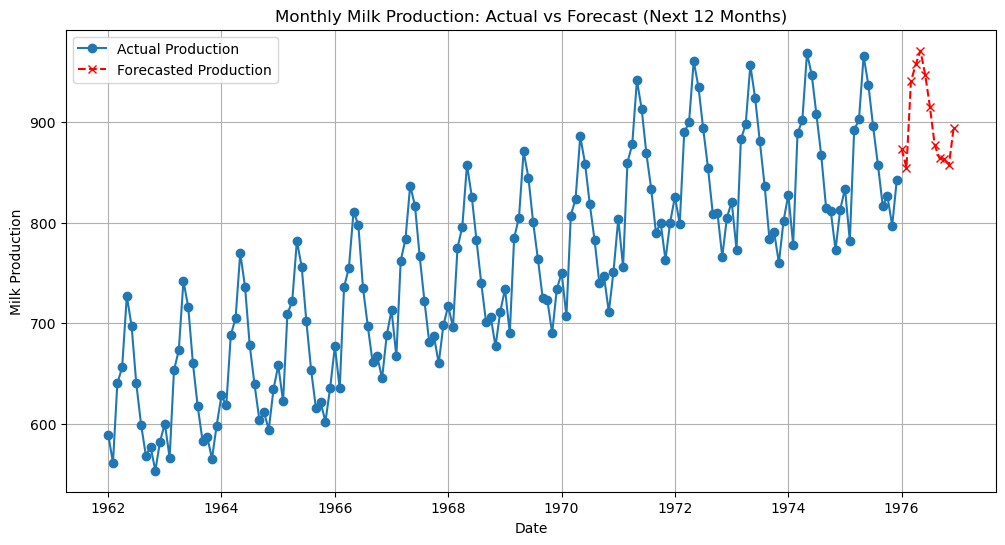

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a time index for the next 12 months
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot actual + predicted
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Production'], label='Actual Production', marker='o')
plt.plot(future_dates, future_predictions, label='Forecasted Production', marker='x', linestyle='--', color='red')
plt.title('Monthly Milk Production: Actual vs Forecast (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.legend()
plt.grid(True)
plt.show()

The RNN model forecasted milk production for the next 12 months, showing a continuation of the historical seasonal trends. The predictions indicate periods of higher and lower production, which the dairy business can use to optimize operations. For example, during predicted high-production months, the business can ensure adequate storage capacity, allocate labor efficiently, and schedule distribution to prevent spoilage. During lower-production months, it can plan procurement and marketing strategies accordingly. Overall, these forecasts enable better inventory management, resource allocation, and informed decision-making, reducing waste and meeting market demand effectively.